# Helper functions and imports


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.special

#ones i added
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, accuracy_score
from prettytable import PrettyTable

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import os
# helper to load data from PNG image files# helpe
import imageio.v2 as imageio
# glob helps select multiple files using patterns
import glob
# helps to manipulate the image for rotation
from __future__ import division # backward compatibility for python2
import operator
import random
np.random.seed(42)


## Import dataset

Import MNIST training and test data.

In [ ]:
# file paths to MNIST on Colab
train_file = "sample_data/mnist_train_small.csv"  # MNIST training data
test_file = "sample_data/mnist_test.csv"  # MNIST test data

## Data Preprocessing

In [ ]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

#all of the train data
y_train_all =  pd.get_dummies(df_orig_train[0]).values # Dataframes converted to ndarrays here
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)
#all of the test data
y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 1500  # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)
#preprocessing normalise training data
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)
print(y_train)

# get a smaller test sample
#test_sample_size = 10000
test_sample_size = 5000
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)
#preprocessing normalise test data
X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 119.8 MB
(20000, 10)
(20000, 784)
(10000, 10)
(10000, 784)
(1500, 10)
(1500, 784)
(1500, 10)
[[0.01 0.01 0.01 ... 0.01 0.01 0.99]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.99 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.99 0.01]
 [0.01 0.99 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.99 ... 0.01 0.01 0.01]]
(5000, 10)
(5000, 784)


In [ ]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """

    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()

    return accuracy




Activation functions
---

We studied the activation functions and used some of them in the labs.

In [ ]:
class Activation_ReLU:
    def forward(self, inputs):
        return np.maximum(0, inputs)
    def backward(self, inputs):
        return np.greater_equal(inputs, 0).astype(int) # inputs >= 0 then convert bools to int

class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

class Activation_LeakyReLU:
    def forward(self, inputs, alpha = 0.0001):
        return np.maximum(alpha*inputs, inputs)
    def backward(self, x, alpha = 0.0001):
        return np.where(x<0, alpha, 1)

class Activation_Linear:
    def forward(self, inputs, m=1, c=0):
      return m * inputs + c # linear equation where m and c can be set
    def backward(self, inputs, m=1, c=0):
      return m

ANN implementation
---


In [ ]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # weights initialised from a gaussian with mean 0 and variance 1
        # multiply with a small value just to ensure we start with small weight values
        self.weights = 0.1*  np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs, act):
        self.inputs = inputs #need this when backpropagating so maintain it in the layer class
        z = np.dot(inputs , self.weights) + self.biases # weights dot product
        self.outputs = act.forward(z) # nonlinear activation output of the layer

    def backward(self, error, act):
        delta = error * act.backward(self.outputs)
        self.dinputs = np.dot(delta, self.weights.T)  #this layer's error

        N = self.dinputs.shape[0]
        self.dweights = np.dot(self.inputs.T, delta) / N  # derivatives for weights used by the optimizer class
        self.dbiases = np.mean(delta, axis=0, keepdims=True) # derivatives for biases used by the optimizer class


class Optimizer_SGD:
    def __init__(self, learningrate=0.3):
           self.lr = learningrate

    def weight_update(self, layer):
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases


In [ ]:
class ANN():
    def __init__(self, ouput_layer, act2, hidden_layer, act1, opt, batch_size = 10):
        self.layer2 = ouput_layer
        self.act2 = act2
        self.layer1 = hidden_layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size
        #for storing resutls from testing
        self.results = []

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, lr=0.3):
        self.opt.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)

                #calculate the loss
                loss=(self.layer2.outputs-batch_y)

                # backprop through the layers
                self.layer2.backward(loss, self.act2)
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2)


            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        return self.layer2.outputs


    def embeddings(self, x, layer_type="layer1"):
        # layer_type defaults to output is useful for prediction
        # layer_type=layer1 is useful to get the compressed respresentation from the hidden layer

        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)

        if layer_type == "layer1":
          return self.layer1.outputs
        return self.layer2.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        self.results = []

        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)

        prediction_labels = np.argmax(pred,axis=1)
        target_labels = np.argmax(y,axis=1)

        for prediction,target in zip(prediction_labels,target_labels):
          self.results.append((prediction, target))


        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)


In [ ]:
# Hyperparameters for your ANN
np.random.seed(42)
batch_size = 20
epochs = 10
lr = 0.3
sgd = Optimizer_SGD()

kNN Implementation
---



In [ ]:
# HELPER FUNCTIONS

#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += pow((val1 - val2), 2)

        distance = pow(distance, 1/2)


        return 1 / (1+ distance)


def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)

        return 1 / (1+ distance)

def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)
#Finally, we can test to see how many of the test instances we got correct
def accuracy_knn(results):
        correct = 0
        for predict, target in results:

            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0

In [ ]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values

    Attributes
    -----------
    Results : list
      Target and predicted class labels for the test data.
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False, use_pca=False, n_components=None):
        self.X_train = X_train
        self.Y_train = Y_train
        self.use_pca = use_pca

        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash

        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean

        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting

        #store results from testing
        self.results= []

        #if pca is used fit the train data
        if self.use_pca:
          self.pca = PCA(n_components=n_components)

          self.X_train = self.pca.fit_transform(X_train)
        else:
          self.pca=None

    #With k-NN, we are interested in finding the k number of points with the greatest similarity
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        if self.use_pca:
          #print(test_instance) prints all 784 feature values(pixels)
          test_instance = self.pca.transform(test_instance.reshape(1, -1))[0] #transforms instance and get first row
          #print(test_instance) prints 50 new feautures generated by PCA(not pixels more line variations)



        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance

            similarities.append((train_instance, y, sim)) #add the features values and label of the example and the computed similarity to a collection
        #print(distances)
        similarities.sort(key = operator.itemgetter(2), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        neighbours = [similarities[x] for x in range(self.k)] #extract the k top indices of the collection for return

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = np.argmax(neighbours[x][1])
            #print(response)
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][2]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][2]][weighted == True]

            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][2])
                #class_votes[response] = [1, neighbours[x][2]][weighted == True]

        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]  # return class with the most votes



    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            #print("Predicted label:", predict_label, "Actual label:", target_label)
            target_class = np.argmax(target_label)
            #print("Predicted label:", predict_label, "Actual label:", target_class)
            self.results.append([predict_label, target_class])
            #print('> predicted = ', result,', actual = ', test_label)


# Machine Identification of Handwritten Digits
---




In [ ]:
# This is a helper method for you to load the data
def get_my_test_data(folder):
    # our own image test data set
    X = []
    y = []

    # to read jpg change the regex to '/*.jpg'
    folder_expr = folder + '/*.png'
    print(folder_expr)

    for image_file_name in glob.glob(folder_expr):
        print ("loading ... ", image_file_name)

        # load image data from png files into an array
        img_array = imageio.imread(image_file_name, mode='F')
        # reshape from 28x28 to list of 784 values, invert values
        img_data  = 255.0 - img_array.reshape(784)
        # then scale data to range from 0.01 to 1.0
        inputs = (img_data / 255.0 * 0.99) + 0.01

        # use the filename to set the correct label
        digit_class = int(image_file_name[-5:-4]) #negative indices for indexing from the end of the array

        X.insert(len(X), inputs)
        y.insert(len(y), digit_class)

        pass
    return(X,y)
pass

## Creating a test set from my own handwriting and read it into my code

my_images/*.png
loading ...  my_images/3-11.png
loading ...  my_images/4-2.png
loading ...  my_images/0-0.png
loading ...  my_images/12-6.png
loading ...  my_images/17-88.png
loading ...  my_images/8-4.png
loading ...  my_images/6-3.png
loading ...  my_images/16-8.png
loading ...  my_images/9-44.png
loading ...  my_images/18-9.png
loading ...  my_images/5-22.png
loading ...  my_images/15-77.png
loading ...  my_images/2-1.png
loading ...  my_images/19-99.png
loading ...  my_images/14-7.png
loading ...  my_images/11-55.png
loading ...  my_images/7-33.png
loading ...  my_images/1-00.png
loading ...  my_images/10-5.png
loading ...  my_images/13-66.png


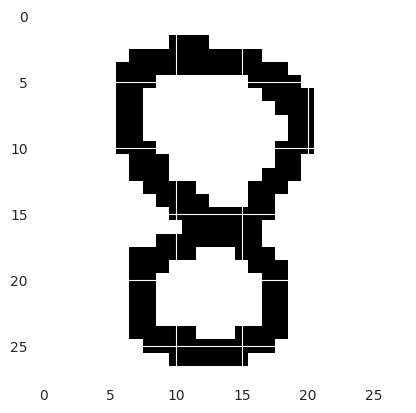

In [ ]:
X_my_test, y_my_test = get_my_test_data('my_images') # my_images is a subfolder in the current folder

# lets plot one of the created images that was read into X_my_test
# now reshape the 784 features into a 28x28 grid
# here asfarray helps to convert values into real numbers
image_array = np.asfarray(X_my_test[4]).flatten().reshape((28,28))

# print the grid in grey scale
plt.imshow(image_array, cmap='Greys', interpolation='None')

In [ ]:
#MNIST dataset assume output_nodes = 10 for the ANN
output_nodes = 10
# converts the data to a format that the ANN class can use for training the model
# this maps a given target class label to an output vector (y_vec) that's compatible
# with the ANN's output layer.
def map_target_to_output_layer(instances, targets):
    X=[]
    Y=[]
    for inputs, target in zip(instances, targets):
        # create the target output values (all 0.01, except the desired label which is 0.99)
        y_vec = np.zeros(output_nodes) + 0.01
        y_vec[int(target)] = 0.99
        #print('output', target)

        X.insert(len(X), inputs) # simply inserting these they are already in the correct format
        Y.insert(len(Y), y_vec) # inserting these after the vector mapping
    pass
    return(np.array(X),np.array(Y))
pass

X_my_test, y_my_test = get_my_test_data('my_images')
X_my_test, y_my_test = map_target_to_output_layer(X_my_test, y_my_test)

my_images/*.png
loading ...  my_images/3-11.png
loading ...  my_images/4-2.png
loading ...  my_images/0-0.png
loading ...  my_images/12-6.png
loading ...  my_images/17-88.png
loading ...  my_images/8-4.png
loading ...  my_images/6-3.png
loading ...  my_images/16-8.png
loading ...  my_images/9-44.png
loading ...  my_images/18-9.png
loading ...  my_images/5-22.png
loading ...  my_images/15-77.png
loading ...  my_images/2-1.png
loading ...  my_images/19-99.png
loading ...  my_images/14-7.png
loading ...  my_images/11-55.png
loading ...  my_images/7-33.png
loading ...  my_images/1-00.png
loading ...  my_images/10-5.png
loading ...  my_images/13-66.png


## Using kNN to identify a sample of size N from the MNIST test dataset that is most similar to the digits I created.

Testing with k=1 and similarity metric=euclidean


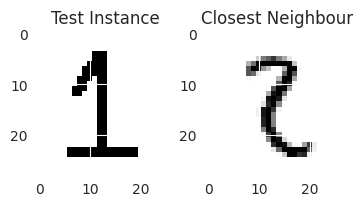

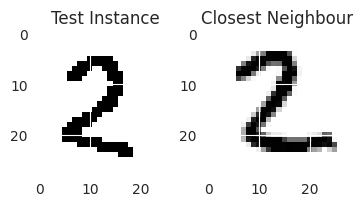

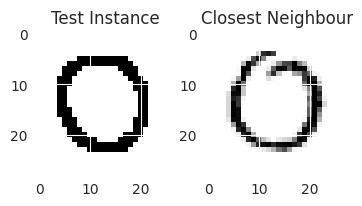

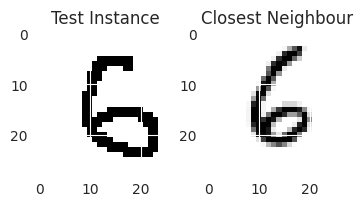

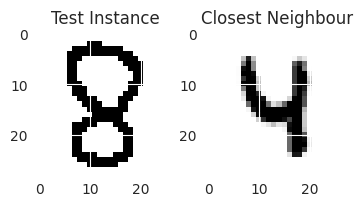

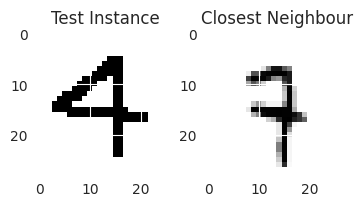

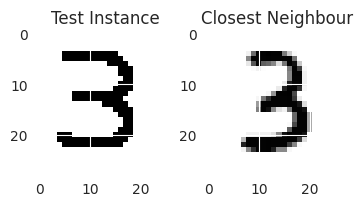

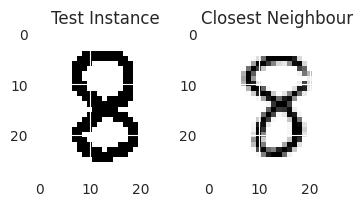

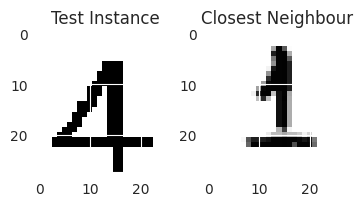

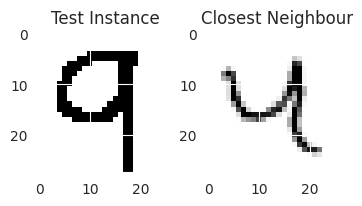

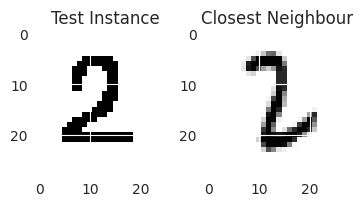

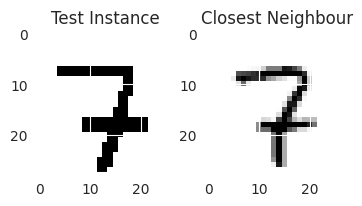

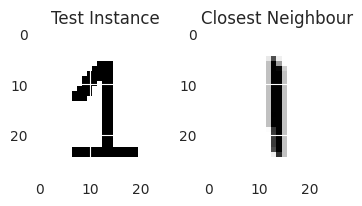

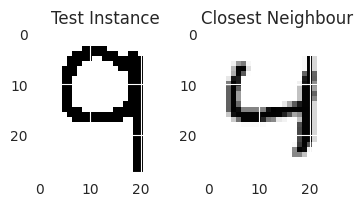

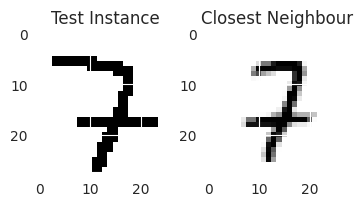

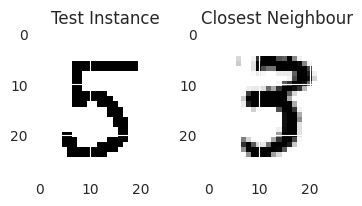

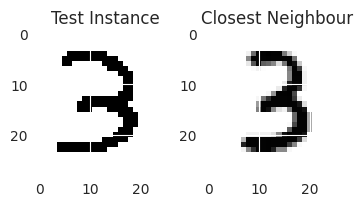

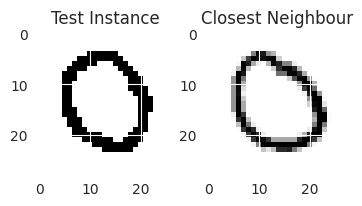

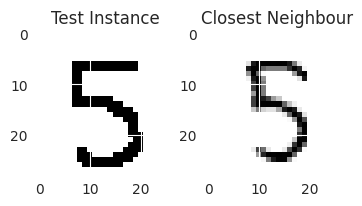

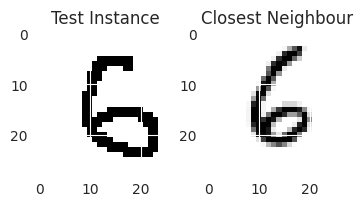

Testing with k=1 and similarity metric=manhattan


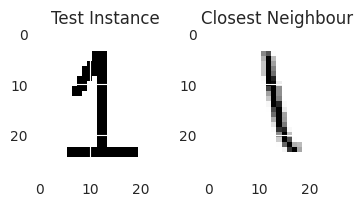

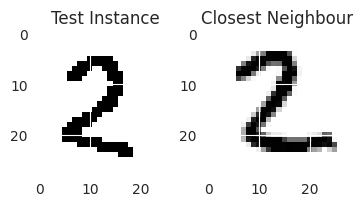

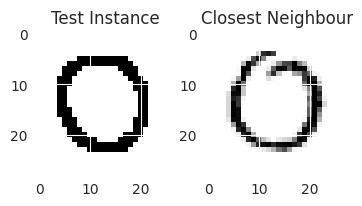

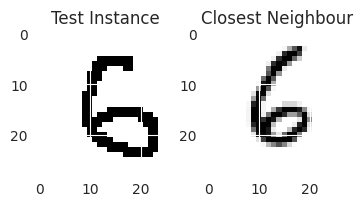

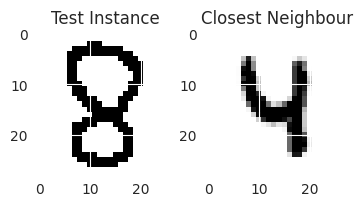

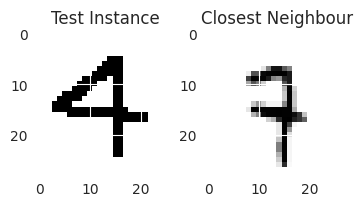

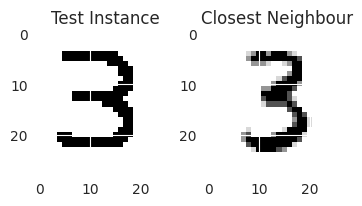

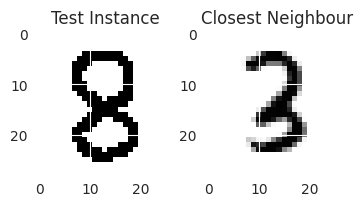

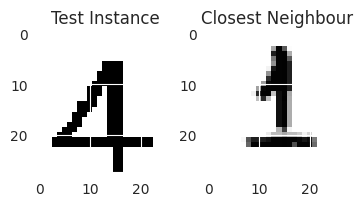

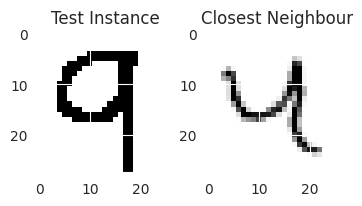

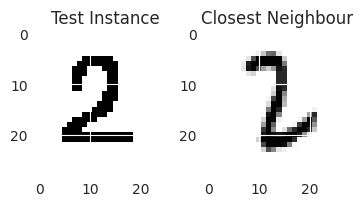

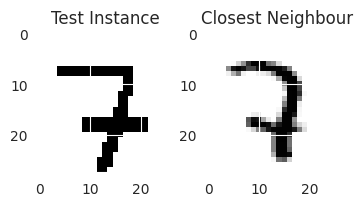

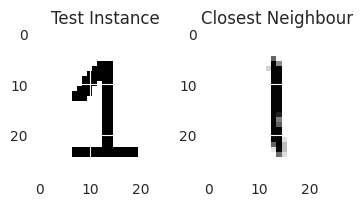

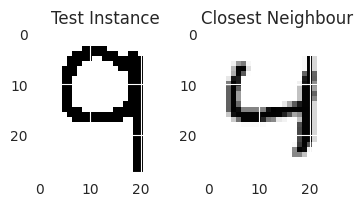

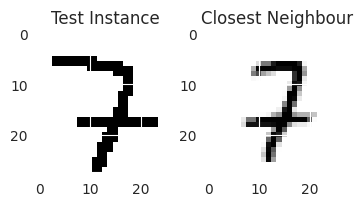

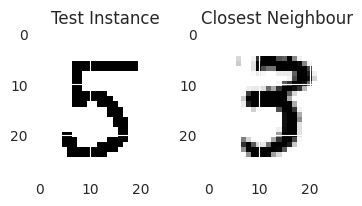

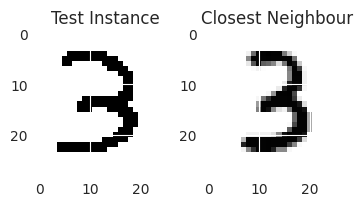

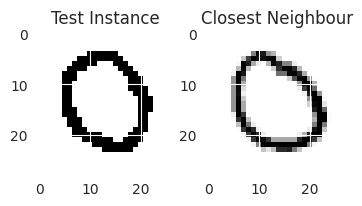

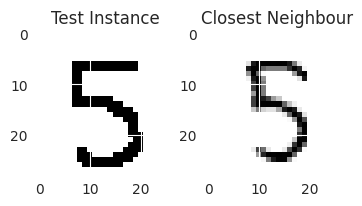

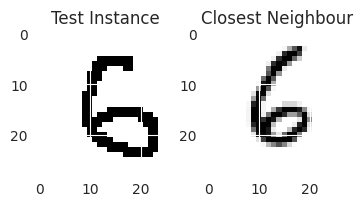

Testing with k=1 and similarity metric=dot_product


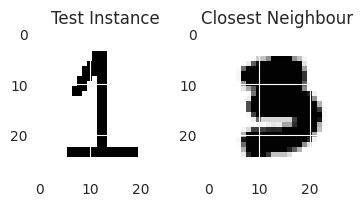

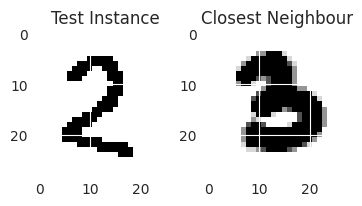

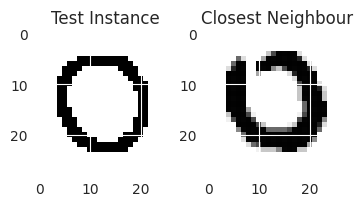

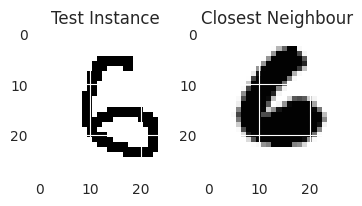

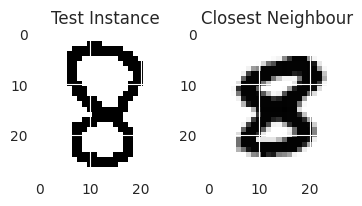

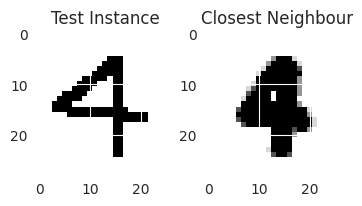

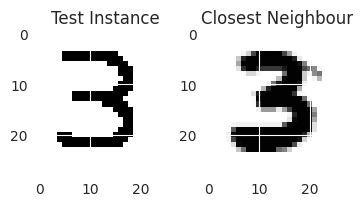

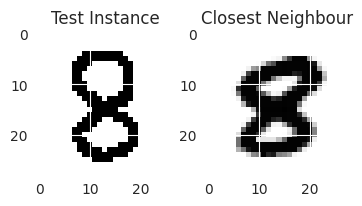

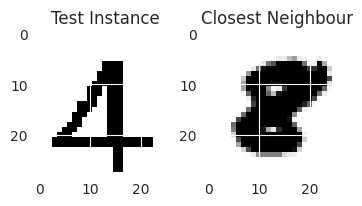

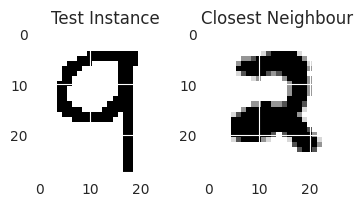

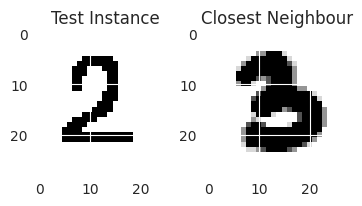

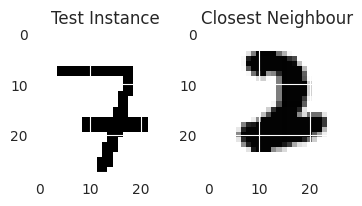

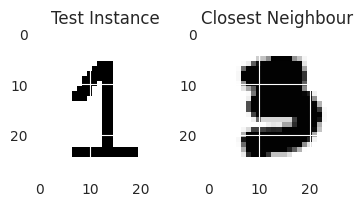

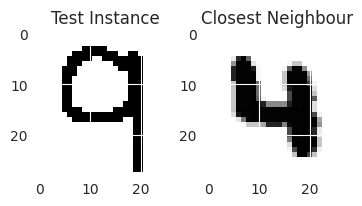

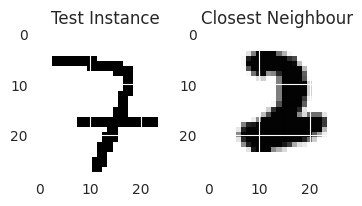

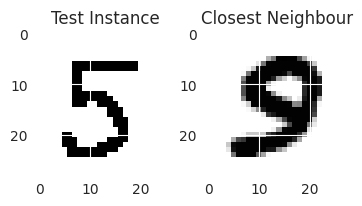

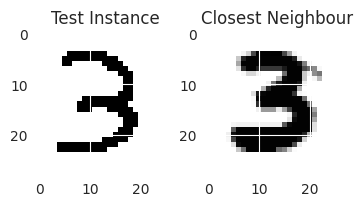

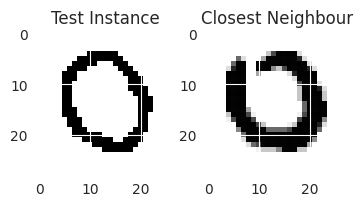

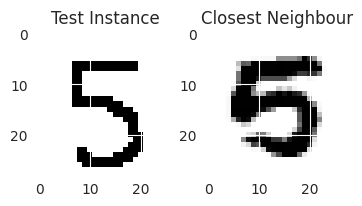

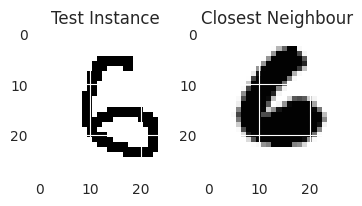

Testing with k=3 and similarity metric=euclidean


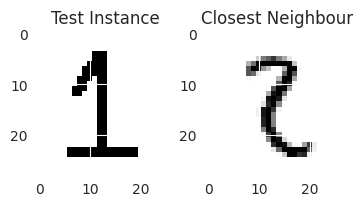

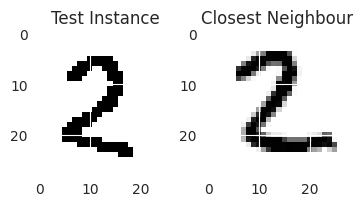

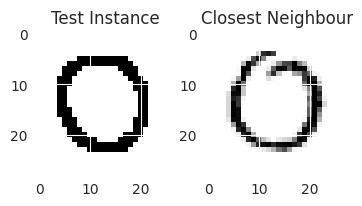

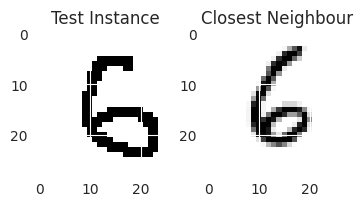

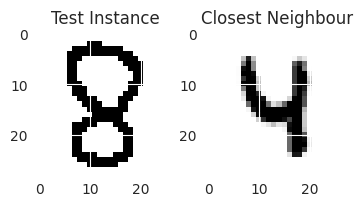

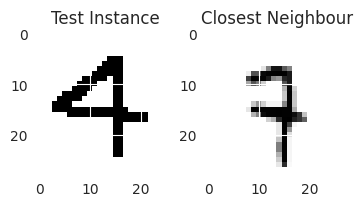

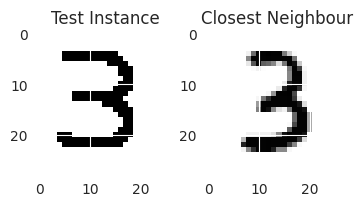

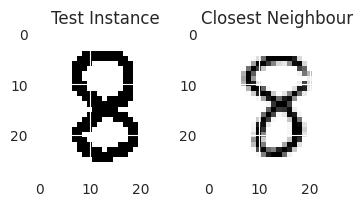

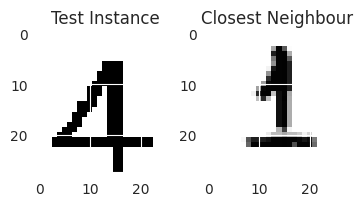

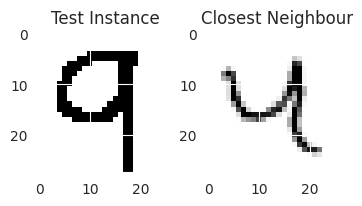

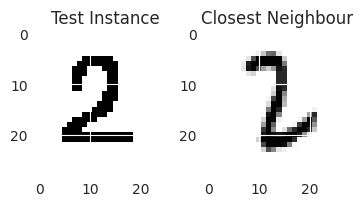

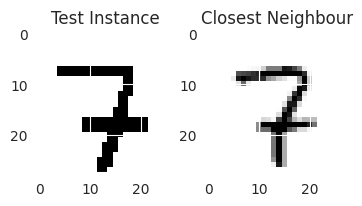

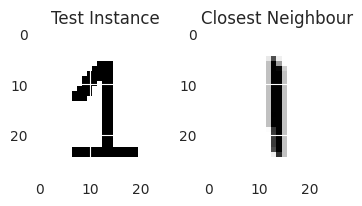

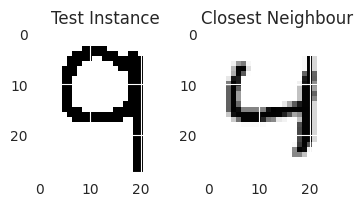

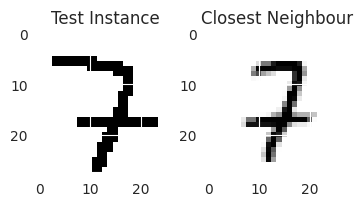

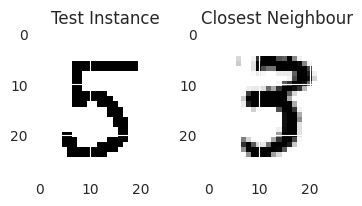

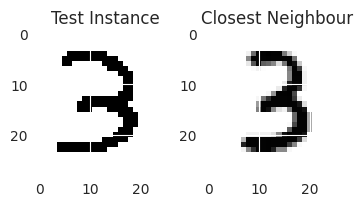

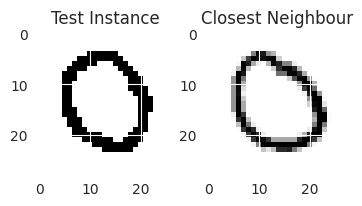

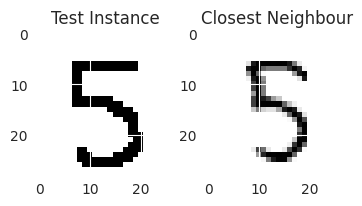

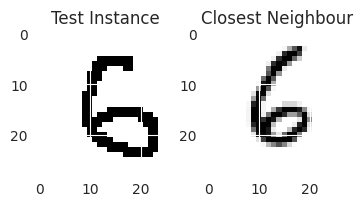

Testing with k=3 and similarity metric=manhattan


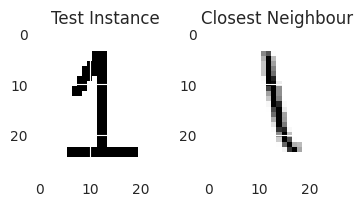

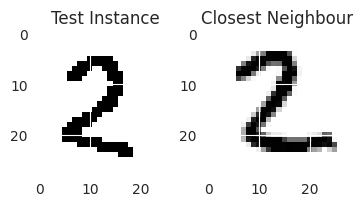

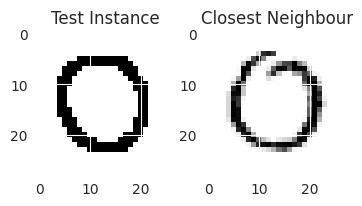

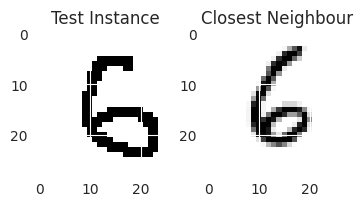

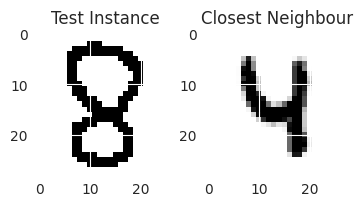

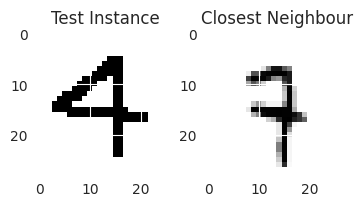

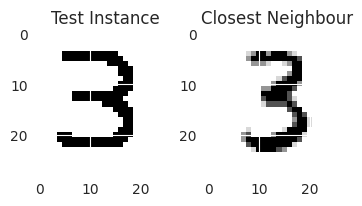

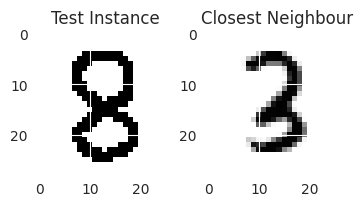

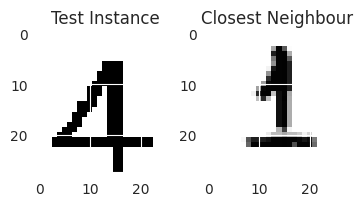

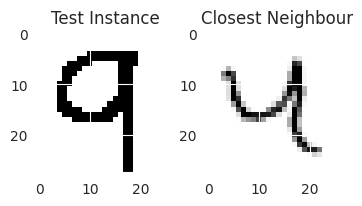

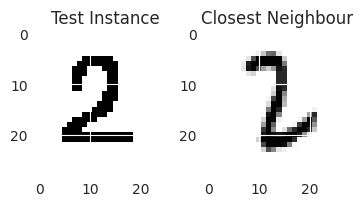

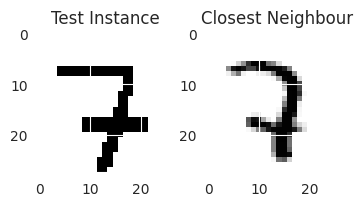

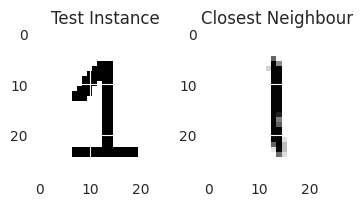

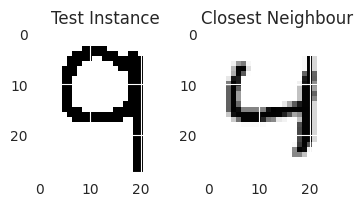

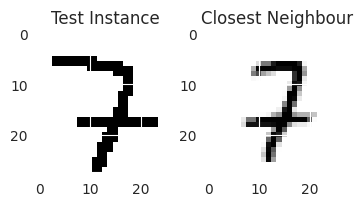

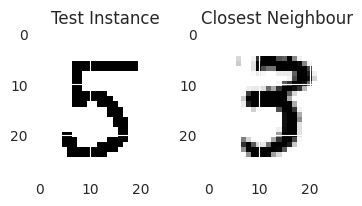

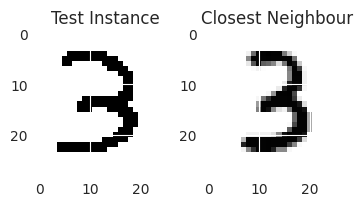

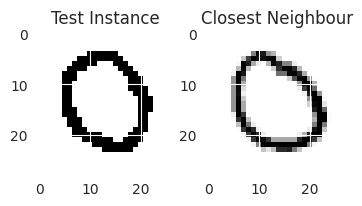

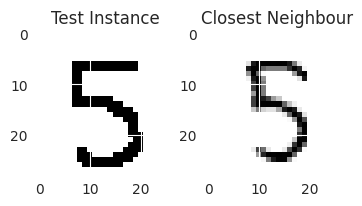

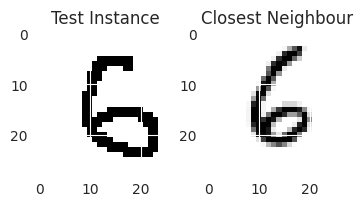

Testing with k=3 and similarity metric=dot_product


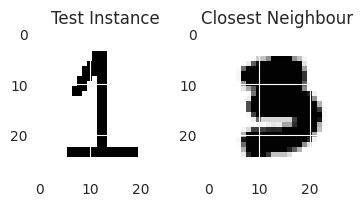

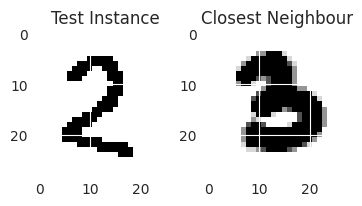

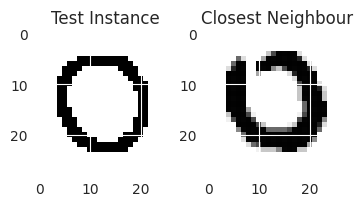

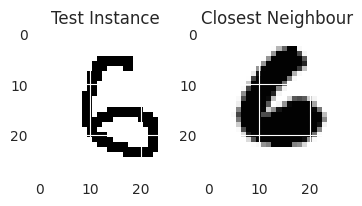

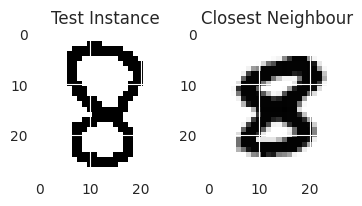

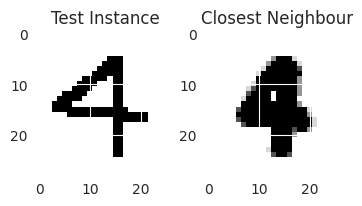

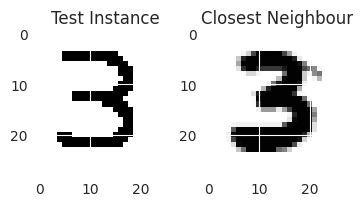

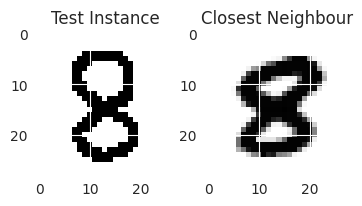

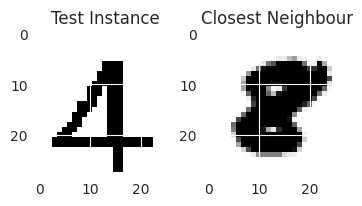

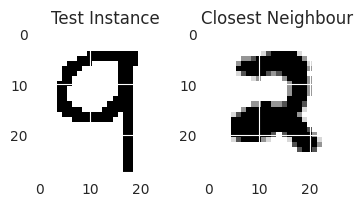

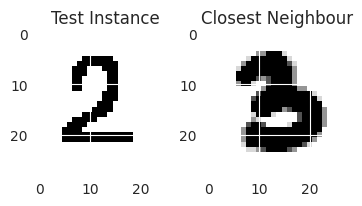

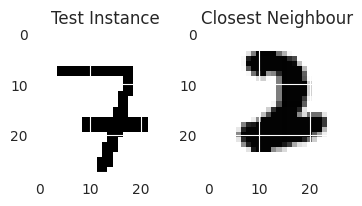

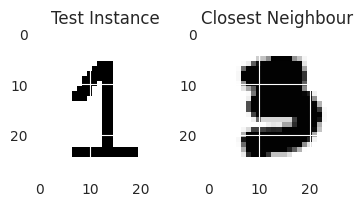

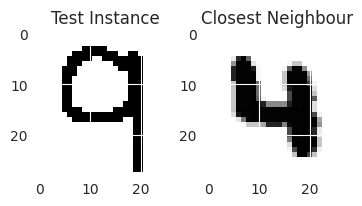

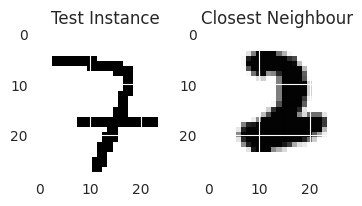

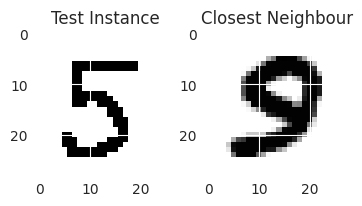

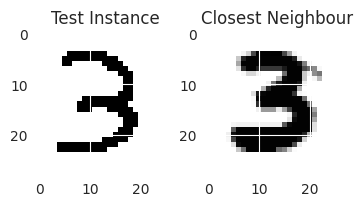

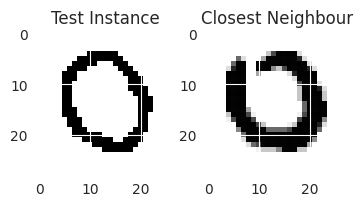

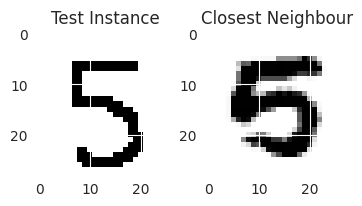

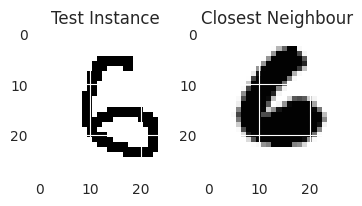

In [ ]:
# testing before using kNN to generate sample

# k values to try
k_values = [1,3]

# similarity metrics to try
sim_metrics = {
    'euclidean': euclidean,
    'manhattan': manhattan,
    'dot_product': dot_product
}

# iterate over each k value
for k in k_values:
    # iterate over each similarity metric
    for sim_name, sim_function in sim_metrics.items():
        print(f"Testing with k={k} and similarity metric={sim_name}")

        # new kNN  with the current k and similarity metric
        knn = kNN(X_test, y_test, k=k, sim=sim_function, weighted=False)

        # get neighbours for each instance in the test set
        for index, test_instance in enumerate(X_my_test):
            neighbours = knn.get_neighbours(test_instance)
             # index of the closest neighbour in X_train
            neighbour_features = neighbours[0][0]

            # reshape the 784 features into a 28x28 grid for both test instance and neighbour
            test_image = np.asfarray(test_instance).reshape((28, 28))
            neighbour_image = np.asfarray(neighbour_features).reshape((28, 28))

            # plotting both images side by side
            plt.figure(figsize=(4,2))


            # test instance
            plt.subplot(1, 2, 1)
            plt.imshow(test_image, cmap='Greys', interpolation='None')
            plt.title('Test Instance ')

            # closest neighbour
            plt.subplot(1, 2, 2)
            plt.imshow(neighbour_image, cmap='Greys', interpolation='None')
            plt.title('Closest Neighbour')

            plt.show()

#tried different metrics and k values , k =3 and sim = dot_product performed best(get the most right)




In [ ]:
# sample generation using kNN here

knn = kNN(X_test,y_test, k=3, sim = dot_product, weighted=True)
X_neighbours = []
y_neighbours = []

for test_instance in X_my_test:

  neighbours = knn.get_neighbours(test_instance)


  for train_instance, label, similarity in neighbours:

    X_neighbours.append(train_instance)
    y_neighbours.append(label)

X_neighbours = np.array(X_neighbours)
y_neighbours = np.array(y_neighbours)

print(y_neighbours[0])

[0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01 0.01]


In [ ]:
#shapes of all three

print(f"X_neighbours shape: {(X_neighbours).shape}")
print(f"y_neighbours shape: {(y_neighbours).shape}")

print(f"X_test shape: {(X_test).shape}")
print(f"y_test shape: {(y_test).shape}")

print(f"my digits shape: {(X_my_test).shape}")
print(f"my digits: {(y_my_test).shape}")

X_neighbours shape: (60, 784)
y_neighbours shape: (60, 10)
X_test shape: (5000, 784)
y_test shape: (5000, 10)
my digits shape: (20, 784)
my digits: (20, 10)


In [ ]:
#print(X_neighbours[0])
#print(y_neighbours)

print(y_train)

[[0.01 0.01 0.01 ... 0.01 0.01 0.99]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.99 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.99 0.01]
 [0.01 0.99 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.99 ... 0.01 0.01 0.01]]


## How I created my images and generated a sample using kNN

<!-- Your explanation will go here -->
Double-click to type here

---

Firstly, I drew digits digitally(0-9) using an online drawingtool which automatically resized them to 28x28 pixels before uploading to Google Collab. This was was done to match the dimensions of the MNIST dataset. Secondly, using the get_neighbours function to identify and retrieve hte nearesest neighbours from the MNIST test datset based on the samples I created.Knn finds the nearest neughbours(based on dot product similarity and weighted voting) for each one of my digits. Then it extracts the feature vectors and labels of these neighbours.Tested a few different k values and similarity metrics to see which ones correctly identified best this was done by plotting the first singluar neighbour against my digit.
Interestingly manhattan and euclidean seem to perform consistently across different k values while dot product showed improvement. Using the dot_product and k = 3 , generated a new dataset of nearest neihgbours with shape X_neighbours shape: (60, 784) y_neighbours shape: (60, 10).
The resulting arrays represent a subset of the test mnist data most similar to the digits I drew.











## Comparing the performance of ANN and kNN on 3 test datasets.

The 3 test datasets for comparison are (1) the handwritten digits I created in earlier, (2) the sample generated by kNN, and (3) a random selection of digits from the MNIST test dataset.

### Determining the performance of ANN on the 3 test datasets.

In [ ]:
#testing different parameters - learning rate and epochs

train_results_list = []

ann_list = []

act1 = Activation_LeakyReLU()
act2 = Activation_Sigmoid()

batch_size = 20
hidden_nodes_ = 200
epochs_ = [1,5,10,20,25]

lrs_ = [0.1,0.3]



# create set of models
for lr in lrs_:
    ann_list_element = [] # first set of nets with a lr
    for epoch in epochs_:
        # configure the layers
        hidden_layer = Layer_Dense(784, hidden_nodes_)
        output_layer = Layer_Dense(hidden_nodes_, 10)

        ann_ = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size) # create a new ANN model with a specific batch size

        train_performance = ann_.train(X_train, y_train, epoch, lr) # train the model

        train_results_list.append(train_performance)
        ann_list_element.append(ann_)

        pass

    ann_list.append(ann_list_element)# append to model list
    pass

# test the models
results_ann = []
model_result_element = []

for model1 in ann_list:
    model_result_element = []

    for model2 in model1:
        #testing on my digits, neighbours and original

        #df_test_result = model2.test(X_test, y_test)

        df_test_result = model2.test(X_my_test, y_my_test)

        #df_test_result = model2.test(X_neighbours, y_neighbours)

        mse=df_test_result['mean_squared_error'].values
        acc=df_test_result['accuracy'].values

        model_result_element.append((mse[0], acc[0]))

        pass
    results_ann.append(model_result_element)
    pass

Text(0.5, 1.0, 'Mean Squared Error Average')

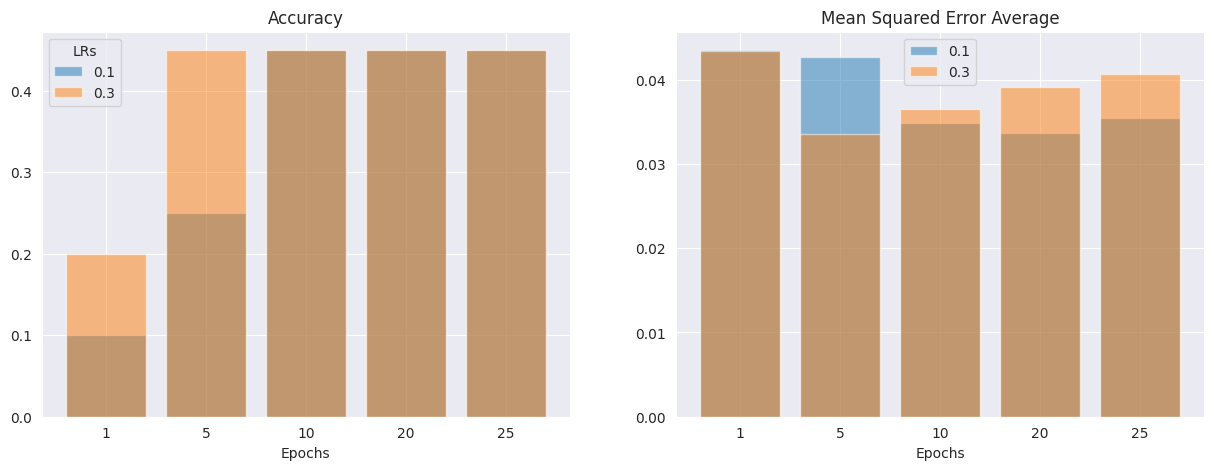

In [ ]:
objects = epochs_
y_pos = np.arange(len(objects))

fig, axes = plt.subplots(1, 2, figsize=(15,5))

for result in results_ann:
    performance_mse = [x[0] for x in result]  # mean squared error
    performance_acc = [x[1] for x in result]  # accuracy

    axes[0].bar(y_pos, performance_acc, align='center', alpha=0.5)  # add accuracy to plot
    axes[1].bar(y_pos, performance_mse, align='center', alpha=0.5)  #  add mean squared error to plot
#plotting results on how it performed on my dataset
y_pos = np.arange(len(objects))

legend0 = axes[0].legend(lrs_, title="LRs")
legend1 = axes[1].legend(lrs_, title="LRs")  #not enough room for this to show :(
#axes[0].legend(lrs_)
axes[0].set_xticks(y_pos)
axes[0].set_xticklabels(objects)
axes[0].set_xlabel('Epochs')
axes[0].set_title('Accuracy')

axes[1].legend(lrs_)
axes[1].set_xticks(y_pos)
axes[1].set_xticklabels(objects)
axes[1].set_xlabel('Epochs')
axes[1].set_title('Mean Squared Error Average')


#ann has the highest accuracy on the mnist data when set to 10 epochs with 0.3lr
#anna has the lowest mse on the mnist data when set to 25 epochs with 0.3lr

#ann has the highest accuracy on the my test data when set to 10 epochs with 0.3lr
#anna has the lowest mse on my test data when set to 5 epochs with 0.3lr

#ann has the highest accuracy on neighbours data when set to 25 epochs with 0.3lr
#anna has the lowest mse on neighbours data when set to 25 epochs with 0.3lr

In [ ]:
# ANN performance evaluation here

input_nodes = 784 #feature values

hidden_nodes = 200

output_nodes = 10 #number of classes

hidden_layer = Layer_Dense(input_nodes, hidden_nodes)
output_layer = Layer_Dense(hidden_nodes, output_nodes)

act1 = Activation_LeakyReLU()
act2 = Activation_Sigmoid()

# creatign the ANN instance
network = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size)



#train it

network.train(X_train,y_train,epochs,lr)

#for neighbours set

performance_neighbours = network.test(X_neighbours, y_neighbours)


print("Performance on Neighbours dataset:")
print(performance_neighbours)

#store prediction and actual lables for later

neighbours_pred_ann = np.array(network.results)


#print(neighbours_pred_ann)


#for original dataset

performance_test= network.test(X_test, y_test)
print("\nPerformance on Original Test dataset:")
print(performance_test)
#store prediction and actual lables for later
mnist_pred_ann = np.array(network.results)
#print(neighbours_pred_ann)

#for my digits dataset

performance_my_test_ = network.test(X_my_test,y_my_test)
#store prediction and actual lables for later
my_pred_ann = np.array(network.results)
#print(my_pred_ann)

print("\nPerformance on My Images dataset:")
print(performance_my_test)


Performance on Neighbours dataset:
   mean_squared_error  accuracy
0            0.016891  0.816667

Performance on Original Test dataset:
   mean_squared_error  accuracy
0            0.011236     0.871

Performance on My Images dataset:
   mean_squared_error  accuracy
0            0.035601      0.55


### Determining the performance of kNN on the 3 test datasets.

Modifing the kNN implementation to be able to use the MNIST datasets. Afterwards,the performance of the modified kNN on the 3 test datasets can be determined.  

In [ ]:
#print(y_neighbours)
#implemented pca into knn for dimension reduction
knn2B = kNN(X_train,y_train, k=2, sim = dot_product, weighted=False, use_pca=True,n_components=50)

print(f"y_test shape: {(y_test).shape}")
print(f"y_my_test shape: {(y_my_test).shape}")
print(f"y_neighbours shape: {(y_neighbours).shape}")



my_p_test = knn2B.test(X_my_test,y_my_test) #20

#store predictions for later
my_pred = knn2B.results
#print(my_pred) #outputs predicted and actual
my_acc = accuracy_knn(knn2B.results)

print(f"Accuracy on my test dataset: {my_acc:.2f}%")
#print(my_p_test)




neighbours_test = knn2B.test(X_neighbours,y_neighbours) #size 60
#store predictions for later
neighbours_pred = knn2B.results

#print(neighbours_pred)

neighbours_acc = accuracy_knn(knn2B.results)


print(f"Accuracy on neighbours dataset: {neighbours_acc:.2f}%")



mnist_test = knn2B.test(X_test,y_test)# size 1000
#store predictions for later
mnist_pred = knn2B.results

#print(mnist_pred)
mnist_acc = accuracy_knn(knn2B.results)

print(f"Accuracy on mnist dataset: {mnist_acc:.2f}%")


y_test shape: (10000, 10)
y_my_test shape: (20, 10)
y_neighbours shape: (60, 10)
Accuracy on my test dataset: 70.00%
Accuracy on neighbours dataset: 83.33%
Accuracy on mnist dataset: 89.32%


# Graphs and Results.





---
Normally ANN would be expected to outperform knn in this task. However when running knn on the mnist test dataset it struggled with processing time even halving the test size didn't fix this issue sufficiently. To address this I integrated Principal Component Analysis(PCA) into the KNN framework.
By using PCA, I reduced the 784 features down to just 50 principal components. This reduction means I kept the most significant parts of the data but in a much more manageable form. This not only sped up KNN significantly but also maintained the essence of the data as shown in the results knn had a 70% accuracy on my dataset compared to 55% using ANN which did not use PCA.This suggest that knn was better suited to the dataset not surprising after pca.  

Referring to the classification reports below,there is a noticeable variation of the performance of knn accross different dataset. Specifically in the dataset of my digits, knn struggles with '8' and '9' as they were correctly identified 0 times. However even in the larger MNIST dataset '9' still had the lowest precision. This suggests knn can struggle with certain digits. An interesting pattern using the neighbours dataset shows some digits('0','2','3','6' and '7') have very high precision and recall while others like '5' and '9' have very low scores. This suggest possibility of unbalanced data which is likely since when neighbours was generated there was no class distribution check.

Again referring to the classification reports below. The results for my dataset show that ANN also struggles significantly with '4' and '9' as indicated by 0.00 precision and recall. With an overall accuracy of 55% this shows potential overfitting and ANN could have benefitted from better tuned parameters.

Overall, both models struggled struggled with the digit '9' the most. More details can be seen below.





In [ ]:
print(" \n--->KNN PERFORMANCE<---")
print(f"\nAccuracy on my test dataset: {my_acc:.2f}%")

print(f"\nAccuracy on neighbours dataset: {neighbours_acc:.2f}%")

print(f"\nAccuracy on mnist dataset: {mnist_acc:.2f}%")

print(" \n--->ANN PERFORMANCE<---")


print("\nPerformance on My Images dataset:")
print(performance_my_test)

print("\nPerformance on Original Test dataset:")
print(performance_test)

print("Performance on Neighbours dataset:")
print(performance_neighbours)


 
--->KNN PERFORMANCE<---

Accuracy on my test dataset: 70.00%

Accuracy on neighbours dataset: 83.33%

Accuracy on mnist dataset: 89.32%
 
--->ANN PERFORMANCE<---

Performance on My Images dataset:
   mean_squared_error  accuracy
0            0.035601      0.55

Performance on Original Test dataset:
   mean_squared_error  accuracy
0            0.011111    0.8756
Performance on Neighbours dataset:
   mean_squared_error  accuracy
0            0.008656  0.933333


Classification Report for My Test Dataset Using kNN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       0.67      1.00      0.80         2
           4       0.33      0.50      0.40         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.70        20
   macro avg       0.65      0.70      0.67        20
weighted avg       0.65      0.70      0.67        20



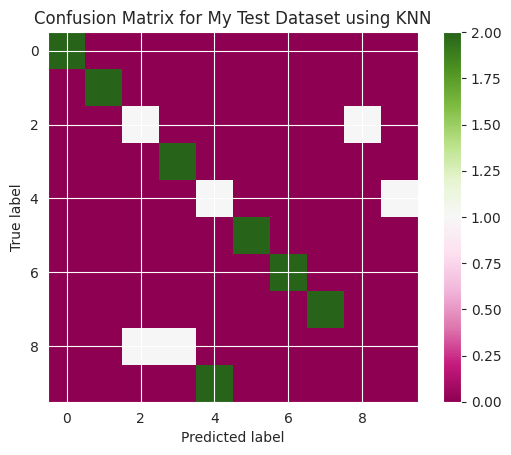

Classification Report for My Dataset using ANN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.50      0.67         2
           2       0.20      0.50      0.29         2
           3       0.50      1.00      0.67         2
           4       0.00      0.00      0.00         2
           5       1.00      0.50      0.67         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         2

    accuracy                           0.55        20
   macro avg       0.62      0.55      0.55        20
weighted avg       0.62      0.55      0.55        20



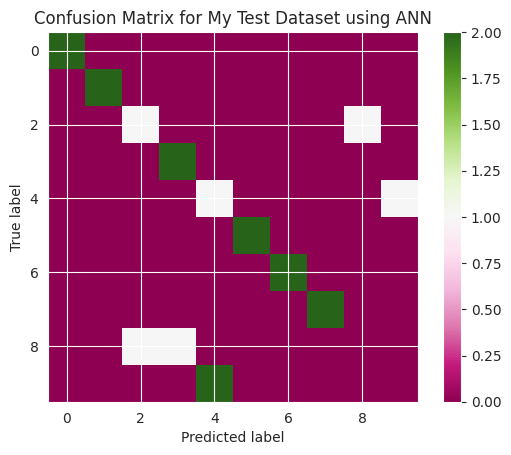

In [ ]:

#using predications from knn earlier

#CLASSIFICATION AND CONFUSION MATRIX FOR MY TEST DATA KNN VS ANN
#labels are returned as 2D array where index[0] is predictions and index[1] are target values


# my test data on knn
my_pred_labels = [pred[0] for pred in my_pred]
my_actual_labels = [pred[1] for pred in my_pred]
my_report = classification_report(my_actual_labels, my_pred_labels)
print("Classification Report for My Test Dataset Using kNN:")
print(my_report)

#confusion matrix my test data on knn
my_conf = confusion_matrix(my_actual_labels,my_pred_labels)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for My Test Dataset using KNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

#shows knn correctly predicted zero instances of 8 or 9

#using predications from ann earlier

#my test data on ann

my_pred_ann_labels = [pred[0] for pred in my_pred_ann]
my_actual_ann_labels = [pred[1] for pred in my_pred_ann]

my_report_ann = classification_report(my_actual_ann_labels, my_pred_ann_labels,zero_division=0)
print("Classification Report for My Dataset using ANN:")
print(my_report_ann)

#confusion matrix for my data using ann
my_conf_ann = confusion_matrix(my_pred_ann_labels,my_actual_ann_labels)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for My Test Dataset using ANN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()





Classification Report for MNIST Dataset using KNN:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       980
           1       0.95      0.99      0.97      1135
           2       0.96      0.86      0.91      1032
           3       0.90      0.86      0.88      1010
           4       0.95      0.78      0.85       982
           5       0.91      0.81      0.86       892
           6       0.92      0.95      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.85      0.86      0.86       974
           9       0.76      0.92      0.83      1009

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



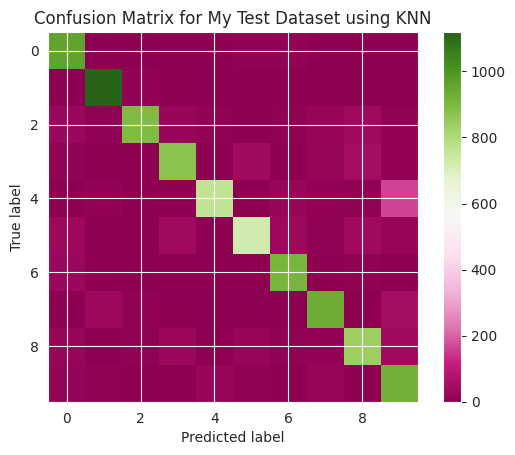


Classification Report for MNIST Dataset using ANN:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       980
           1       0.89      0.99      0.93      1135
           2       0.91      0.81      0.86      1032
           3       0.87      0.88      0.88      1010
           4       0.91      0.86      0.88       982
           5       0.90      0.67      0.77       892
           6       0.90      0.92      0.91       958
           7       0.90      0.89      0.90      1028
           8       0.81      0.82      0.81       974
           9       0.79      0.90      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.88      0.87     10000



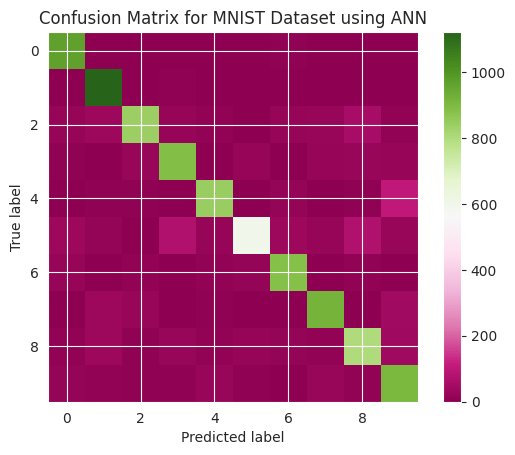

In [ ]:
#CLASSIFICATION AND CONFUSION MATRIX FOR MNIST DATA KNN VS ANN
#USING PREDICTIONS FROM EARLIER

# mnist test dataset on knn
#labels are returned as 2D array where index[0] is predictions and index[1] are target values

mnist_pred_labels = [pred[0] for pred in mnist_pred]
mnist_actual_labels = [pred[1] for pred in mnist_pred]

report_mnist = classification_report(mnist_actual_labels, mnist_pred_labels)
print("\nClassification Report for MNIST Dataset using KNN:")
print(report_mnist)

#confusion matrix for mnist on knn
my_conf = confusion_matrix(mnist_actual_labels,mnist_pred_labels)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for My Test Dataset using KNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

# mnist test dataset on ann
mnist_pred_labels_ann = [pred[0] for pred in mnist_pred_ann]
mnist_actual_labels_ann= [pred[1] for pred in mnist_pred_ann]
report_mnist_ann = classification_report(mnist_actual_labels_ann, mnist_pred_labels_ann)
print("\nClassification Report for MNIST Dataset using ANN:")
print(report_mnist_ann)

#confusion matrix for mnist on ann
my_conf = confusion_matrix(mnist_actual_labels_ann,mnist_pred_labels_ann)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for MNIST Dataset using ANN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report for Neighbours Dataset using KNN:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71         6
           2       1.00      0.73      0.85        15
           3       1.00      0.83      0.91        12
           4       1.00      0.67      0.80         3
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         1
           8       0.75      0.94      0.83        16
           9       0.00      0.00      0.00         1

    accuracy                           0.83        60
   macro avg       0.70      0.69      0.68        60
weighted avg       0.85      0.83      0.83        60



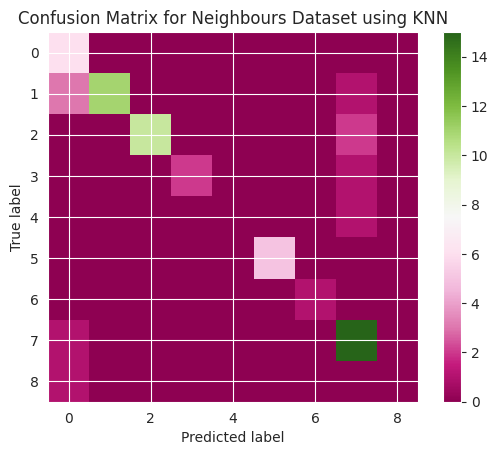


Classification Report for Neighbours Dataset using ANN:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           2       1.00      0.87      0.93        15
           3       1.00      1.00      1.00        12
           4       1.00      0.67      0.80         3
           5       0.50      1.00      0.67         1
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        16
           9       0.00      0.00      0.00         1

    accuracy                           0.93        60
   macro avg       0.81      0.84      0.81        60
weighted avg       0.95      0.93      0.94        60



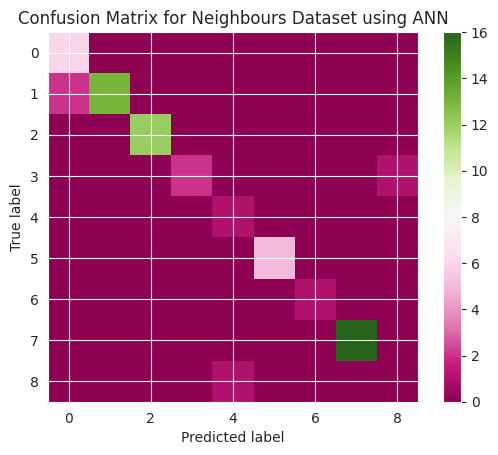

In [ ]:
#CLASSIFICATION AND CONFUSION MATRIX FOR NEIGHBOURS TEST KNN VS ANN
#USING PREDICTIONS FROM EARLIER

# neighbours test dataset on knn
#labels are returned as 2D array where index[0] is predictions and index[1] are target values

neighbours_pred_labels = [pred[0] for pred in neighbours_pred]
neighbours_actual_labels = [pred[1] for pred in neighbours_pred]

report_neighbours = classification_report(neighbours_actual_labels, neighbours_pred_labels)
print("\nClassification Report for Neighbours Dataset using KNN:")
print(report_neighbours)

#confusion matrix for mnist on knn
my_conf = confusion_matrix(neighbours_actual_labels, neighbours_pred_labels)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for Neighbours Dataset using KNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()

# mnist test dataset on ann
neighbours_pred_labels_ann = [pred[0] for pred in neighbours_pred_ann]
neighbours_actual_labels_ann= [pred[1] for pred in neighbours_pred_ann]
report_neighbours_ann = classification_report(neighbours_actual_labels_ann, neighbours_pred_labels_ann)
print("\nClassification Report for Neighbours Dataset using ANN:")
print(report_neighbours_ann)

#confusion matrix for mnist on ann
my_conf = confusion_matrix(neighbours_actual_labels_ann,neighbours_pred_labels_ann)
plt.imshow(my_conf, cmap="PiYG", interpolation='None')
plt.title('Confusion Matrix for Neighbours Dataset using ANN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.colorbar()
plt.show()


#both knn and ann struggled most with '9'